## Capstone Project - The Battle of Neighborhoods
### Notebook for Applied Data Science Capstone final assignment
#### Title: Investment Regions Analysis - Capstone Project Final - Injeti

__Author:__ Isaac Injeti <br>
__Date:__ Jan 14th, 2019

### Introduction - Problem Statement:
__Audience:__ Cafe Investors seeking to capitalize on the recent growth of the Vizag (Visakhapatnam) city region within Andhra Pradesh, India. <br>
__Problem:__ Investors have been investing in various cafes in the area based on projected growth in the city. Unfortunately, a number of those ventures have failed because of their locations. As everyone knows, the key to success here is always location, location, location. In order to reduce the chance of failure again, investors are wanting to understand what areas of the city would be the most profitable areas to begin a new cafe venture based on the characteristics of the area in which the top cafe currently operates in the city.

### How? - The Data:
__Data Sources will be:__<br>
 - Extract of Areas (neighborhoods) of Vizag from Wikipedia: http://bit.ly/vskp_wikipedia
 - Zip codes extracted from: http://bit.ly/vskp_pincodes
 - geocode extract of coordinates
 - Foursquare exploration data
 
__The multiple datasets will be combined into a consumable framework from which areas will be clustered based on type of businesses, popularity, and distance from city hubs. This will then be visualized using a folium map to show the areas most similar to the area in which the top cafe is located.__

Additional datasets may be incorporated as discovered and needed. 

If available, data pertaining to the age of the business would be included.

In [1]:
import requests
import json
import folium
import geopy.distance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
#Start extracting html with areas of Visakhapatnam from wiki page
wiki = 'https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Visakhapatnam'

In [3]:
html = requests.get(wiki)
raw_html = html.text
soup2 = BeautifulSoup(raw_html, 'html.parser')
soup2

<!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>Category:Neighbourhoods in Visakhapatnam - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":14,"wgPageName":"Category:Neighbourhoods_in_Visakhapatnam","wgTitle":"Neighbourhoods in Visakhapatnam","wgCurRevisionId":815357884,"wgRevisionId":815357884,"wgArticleId":37085396,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Commons category link is on Wikidata","Commons category link is on Wikidata using P373","Neighbourhoods in Andhra Pradesh","Geography of Visakhapatnam"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSepar

In [4]:
#In reviewing the html above, I found that the mw-category-group class contained the areas I need
divs = soup2.findAll('div', attrs={'class':'mw-category-group'})

In [5]:
#Creating a list of areas based on the data from the mw-category-group class above
wiki_areas = []
for a in divs:
    aname = a.text.strip() # strip() is used to remove starting and trailing
    wiki_areas.append(aname.splitlines())
    
#Check first item from the new list
wiki_areas[0]

['A',
 'Abidnagar',
 'Adavivaram',
 'Aganampudi',
 'Akkayyapalem',
 'Akkireddypalem',
 'Allipuram',
 'Anakapalle',
 'Anandapuram',
 'Arilova',
 'Asilmetta',
 'Atchutapuram']

In [6]:
#List was created including the Alphabet Index from the page.
#Will wrangle data into consolidated flat list by inserting into dataframe

In [7]:
wiki_df = pd.DataFrame({'Area':wiki_areas})

In [8]:
new = []
for name in wiki_df['Area']:
    new.append(name[1:])
    
new[0:3]

[['Abidnagar',
  'Adavivaram',
  'Aganampudi',
  'Akkayyapalem',
  'Akkireddypalem',
  'Allipuram',
  'Anakapalle',
  'Anandapuram',
  'Arilova',
  'Asilmetta',
  'Atchutapuram'],
 ['Beach Road, Visakhapatnam', 'Bheemunipatnam'],
 ['CBM Compound',
  'Chengal Rao Peta',
  'Chinagantyada',
  'Chinna Gadhili',
  'Chinna Waltair',
  'Chinnamushidiwada',
  'Chintalagraharam']]

In [9]:
#Now that our index alphabet was removed, we can flatten the list
wikiA_list = [item for lst in new for item in lst]
wikiA_list[:15]

['Abidnagar',
 'Adavivaram',
 'Aganampudi',
 'Akkayyapalem',
 'Akkireddypalem',
 'Allipuram',
 'Anakapalle',
 'Anandapuram',
 'Arilova',
 'Asilmetta',
 'Atchutapuram',
 'Beach Road, Visakhapatnam',
 'Bheemunipatnam',
 'CBM Compound',
 'Chengal Rao Peta']

In [10]:
#Place this new list back into a dataframe and clean up text that contains any string other than the area name
wiki_df = pd.DataFrame({'Area':wikiA_list})
wiki_df['Area'] = wiki_df['Area'].str.replace(', Visakhapatnam', '')

#in reviewing the data I noticed a row that was not a valid area name so will remove it
wiki_df = wiki_df.drop(wiki_df[wiki_df.Area == 'Template:Neighbourhoods of Visakhapatnam'].index)

#validate the row was removed
wiki_df[60:70]

,Area
60,NAD X Road
61,Nadupuru
62,Naidu Thota
63,Narava
64,Nathayyapalem
66,One Town (Visakhapatnam)
67,Padmanabham
68,Pandurangapuram
69,Parawada
70,Pedagantyada


In [11]:
wiki_df.reset_index(drop=True,inplace=True)
wiki_df.head()

,Area
0,Abidnagar
1,Adavivaram
2,Aganampudi
3,Akkayyapalem
4,Akkireddypalem


In [12]:
#Now we will create a new column with the search term to be used to extract geo coordinates
wiki_df['search_add'] = wiki_df['Area']+', Visakhapatnam, AP India'

In [13]:
#since there sometimes is a limit on geocode queries, let us first get a subset for testing to ensure we are getting valid coordinates
sub = wiki_df.head() #This will give us a dataset of the first 5 rows
sub

,Area,search_add
0,Abidnagar,"Abidnagar, Visakhapatnam, AP India"
1,Adavivaram,"Adavivaram, Visakhapatnam, AP India"
2,Aganampudi,"Aganampudi, Visakhapatnam, AP India"
3,Akkayyapalem,"Akkayyapalem, Visakhapatnam, AP India"
4,Akkireddypalem,"Akkireddypalem, Visakhapatnam, AP India"


### Now we will configure our geocode function to use Nominatim to get our coordinates

In [14]:
geolocator = Nominatim(user_agent="my-application")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)#use rate limit to set reasonable delay

In [15]:
sub['location'] = sub['search_add'].apply(geocode)
sub['point'] = sub['location'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None)
sub

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Area,search_add,location,point
0,Abidnagar,"Abidnagar, Visakhapatnam, AP India",None,None
1,Adavivaram,"Adavivaram, Visakhapatnam, AP India","(Adavivaram school, 18-128/2, Simhachalam Road...","(17.77782465, 83.2506591504343)"
2,Aganampudi,"Aganampudi, Visakhapatnam, AP India","(Aganampudi, Visakhapatnam District, Andhra Pr...","(17.6860122, 83.1354763)"
3,Akkayyapalem,"Akkayyapalem, Visakhapatnam, AP India","(Akkayyapalem Main Road, Lalitha Nagar, Sriniv...","(17.7274872, 83.2990879)"
4,Akkireddypalem,"Akkireddypalem, Visakhapatnam, AP India",None,None


In [16]:
#Test looks good. Now let us apply geocode to main dataset. This will take over a minute or two given the # of rows
wiki_df['location'] = wiki_df['search_add'].apply(geocode)
wiki_df['point'] = wiki_df['location'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None)

#After getting the coordinates, there will likely be some None values and we will drop those from our dataset
new_w_df = wiki_df.dropna(axis = 0, how ='any')
new_w_df.shape

(61, 4)

In [17]:
#separate lat and lng from point column
new_w_df['lat'] = new_w_df.point.apply(lambda x: x[0])
new_w_df['lng'] = new_w_df.point.apply(lambda x: x[1])
new_w_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Area,search_add,location,point,lat,lng
1,Adavivaram,"Adavivaram, Visakhapatnam, AP India","(Adavivaram school, 18-128/2, Simhachalam Road...","(17.77782465, 83.2506591504343)",17.777825,83.250659
2,Aganampudi,"Aganampudi, Visakhapatnam, AP India","(Aganampudi, Visakhapatnam District, Andhra Pr...","(17.6860122, 83.1354763)",17.686012,83.135476
3,Akkayyapalem,"Akkayyapalem, Visakhapatnam, AP India","(Akkayyapalem Main Road, Lalitha Nagar, Sriniv...","(17.7274872, 83.2990879)",17.727487,83.299088
6,Anakapalle,"Anakapalle, Visakhapatnam, AP India","(Anakapalle, Visakhapatnam District, Andhra Pr...","(17.68897, 83.003476)",17.688970,83.003476
7,Anandapuram,"Anandapuram, Visakhapatnam, AP India","(Anandapuram, Visakhapatnam District, Andhra P...","(17.6425704, 82.8291128)",17.642570,82.829113


In [18]:
#get initial map lat,lng location coordinates for Visakhapatnam
geocode('Visakhapatnam, AP, India')

Location(Visakhapatnam, Visakhapatnam District, Andhra Pradesh, 530001, India, (17.7231276, 83.3012842, 0.0))

### Now we will use our areas with the Latitude and Longitude coordinates to plot the areas on a Folium map

In [19]:
mapVSKP = folium.Map(location=[17.7231276, 83.3012842], zoom_start=12)
mapVSKP

In [20]:
#Now let us add markers for each of the areas we found to the map
for lat, lng, area in zip(new_w_df['lat'], new_w_df['lng'], new_w_df['Area']):
    label = folium.Popup(area, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=0.5).add_to(mapVSKP)

mapVSKP

In [21]:
#Cluster similar neighborhoods together and then locate which neighborhood has the highest rated cafe. 
#Make recommendation based on similar neighborhoods
#Before preceeding further, we need to fix some errors in the neighborhood coordinates

In [22]:
#In reviewing the map, the location of Gopalpatnam was marked incorrectly.
new_w_df[new_w_df.Area=='Gopalapatnam']

,Area,search_add,location,point,lat,lng
33,Gopalapatnam,"Gopalapatnam, Visakhapatnam, AP India","(Gopalapatnam, Visakhapatnam District, Andhra ...","(17.3288019, 82.6116421)",17.328802,82.611642


### Please Note: At this point, I discovered that using the area names was affecting the accuracy of my location coordinates. After browsing the web for alternative approaches, I found a webpage containing the Area Zip (pin) codes for each postal area in the region and decided to go with the zip codes instead of area names. 

In [23]:
geocode('530001, AP, India')

Location(Visakhapatnam District, Andhra Pradesh, 530001, India, (17.7231276, 83.3012842, 0.0))

In [24]:
#Use new url source of pin codes to extract and create a new dataframe
pins = 'https://www.mapsofindia.com/pincode/india/andhra-pradesh/visakhapatnam/'

### Please Note: When reviewing the html, I noticed the zip codes were already in a table structure on the page so I decided to take a simplified approach to load the table into a pandas dataframe using pd.read_html

In [25]:
pin_df = pd.read_html(pins)

#set our df = to the first table loaded from the html
pin_df = pin_df[0].dropna(axis=0, thresh=0)

#set the names of the columns based on the first row in the dataframe and delete the original index
pin_df.columns = pin_df.iloc[1]
pin_df = pin_df.reindex(pin_df.index.drop(1))
pin_df = pin_df.reindex(pin_df.index.drop(0))
pin_df.reset_index(drop=True,inplace=True)
pin_df.shape

(649, 4)

In [26]:
#Once again, we need to create an additional column with our search term to use for getting the geo coordinates
pin_df['search_add'] = pin_df['Pincode']+', AP India'
pin_df.head()

1,Location,Pincode,State,District,search_add
0,A Koduru,531022,Andhra Pradesh,Visakhapatnam,"531022, AP India"
1,A Kothapalle,531022,Andhra Pradesh,Visakhapatnam,"531022, AP India"
2,A U engg college,530003,Andhra Pradesh,Visakhapatnam,"530003, AP India"
3,A Veeranarayanam,531027,Andhra Pradesh,Visakhapatnam,"531027, AP India"
4,Adakula,531115,Andhra Pradesh,Visakhapatnam,"531115, AP India"


In [27]:
#Many of the codes were outside of our target region. 
#We will narrow down the areas to those within the main city code limit
cen = pin_df[pin_df.Pincode < '531000']
cen.shape

(69, 5)

In [28]:
#Take the new dataframe and apply our geocode function to get coordinates. This may take a few minutes to run
cen['location'] = cen['search_add'].apply(geocode)
cen['point'] = cen['location'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
#Let us drop any areas with missing coordinates and reset the index
new_cen = cen.dropna(axis = 0, how ='any')
new_cen.reset_index(drop=True,inplace=True)
new_cen.head()

1,Location,Pincode,State,District,search_add,location,point
0,A U engg college,530003,Andhra Pradesh,Visakhapatnam,"530003, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.7290377, 83.3146114)"
1,Aerodrome,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)"
2,Aganampudi,530046,Andhra Pradesh,Visakhapatnam,"530046, AP India","(Visakhapatnam District, Andhra Pradesh, 53004...","(17.6955177320924, 83.1632765525447)"
3,Airport,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)"
4,Akkayyapalem,530016,Andhra Pradesh,Visakhapatnam,"530016, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.72836385, 83.3051768022714)"


In [30]:
#For convenience later, let us pull out the lat and lng coordinates into separate columns
new_cen['lat'] = new_cen.point.apply(lambda x: x[0])
new_cen['lng'] = new_cen.point.apply(lambda x: x[1])
new_cen.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1,Location,Pincode,State,District,search_add,location,point,lat,lng
0,A U engg college,530003,Andhra Pradesh,Visakhapatnam,"530003, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.7290377, 83.3146114)",17.729038,83.314611
1,Aerodrome,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)",17.744818,83.237808
2,Aganampudi,530046,Andhra Pradesh,Visakhapatnam,"530046, AP India","(Visakhapatnam District, Andhra Pradesh, 53004...","(17.6955177320924, 83.1632765525447)",17.695518,83.163277
3,Airport,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)",17.744818,83.237808
4,Akkayyapalem,530016,Andhra Pradesh,Visakhapatnam,"530016, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.72836385, 83.3051768022714)",17.728364,83.305177


In [31]:
#Now that our area data is ready, let us create a map and plot the new areas
VSKP = folium.Map(location=[17.7231276, 83.3012842], zoom_start=12)

#Once the map is initialized above, we can add markers to plot our new central areas
for lat, lng, area in zip(new_cen['lat'], new_cen['lng'], new_cen['Location']):
    label = folium.Popup(area, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=0.5).add_to(VSKP)

VSKP

### Please Note: Having reviewed the new areas plotted on the map, the region still spans a larger region than we are targetting. I am going to take another approach to narrow down our target areas by getting the distance of each area from the central city postal code using the initial coordinates for Visakhapatnam's 530001 area code. In order to get the distance, we will use a function that compares our central point to lat, lng coordinates for each area and uses geopy's distance method to get km distance from our central point.

In [32]:
#create function to get distance
def dist(coords_2):
    center = (17.7231276, 83.3012842)
    return(geopy.distance.geodesic(center, coords_2).km)

In [33]:
#Create a new column for our distance by applying our function
new_cen['km_from_center'] = new_cen['point'].apply(lambda x: dist(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
new_cen.head()

1,Location,Pincode,State,District,search_add,location,point,lat,lng,km_from_center
0,A U engg college,530003,Andhra Pradesh,Visakhapatnam,"530003, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.7290377, 83.3146114)",17.729038,83.314611,1.557586
1,Aerodrome,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)",17.744818,83.237808,7.147656
2,Aganampudi,530046,Andhra Pradesh,Visakhapatnam,"530046, AP India","(Visakhapatnam District, Andhra Pradesh, 53004...","(17.6955177320924, 83.1632765525447)",17.695518,83.163277,14.954981
3,Airport,530009,Andhra Pradesh,Visakhapatnam,"530009, AP India","(Jaggayyapalem, Visakhapatnam, Visakhapatnam D...","(17.744818, 83.237808)",17.744818,83.237808,7.147656
4,Akkayyapalem,530016,Andhra Pradesh,Visakhapatnam,"530016, AP India","(Srinivasa Nagar, Visakhapatnam, Visakhapatnam...","(17.72836385, 83.3051768022714)",17.728364,83.305177,0.711567


In [35]:
#Narrow down scope to a 10 km radius of Visakhapatnam center pin code 530001
central = new_cen[new_cen.km_from_center < 10]
central.shape

(21, 10)

### Please note: After reviewing the output and plotting on a map, I noticed that there were duplicate points in the data. To get a final list of areas to work with, I am going to remove the duplicates based on our point coordinates

In [36]:
central.drop_duplicates(subset='point',inplace=True)
central.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(14, 10)

In [37]:
#Once again, let us create our map and add our new area plots to the map
VSKP = folium.Map(location=[17.7231276, 83.3012842], zoom_start=12)

for lat, lng, area in zip(central['lat'], central['lng'], central['Location']):
    label = folium.Popup(area)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(VSKP)
    
VSKP

In [38]:
#VSKP.save(outfile = "vizag.html")

### Now that we have a final list of target areas, we can get Foursquare venue data to determine what each of these areas are like so that we can cluster areas by similarity in venues

In [39]:
#The credential information required has been removed for sharing

CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20190117'
LIMIT = 500

In [40]:
#We will use the function below to consolidate a dataset of venues for each area in our dataset
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area_Latitude', 
                  'Area_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category','Venue_id']
    
    return(nearby_venues)

In [41]:
#Run the function to create a new data frame with venue data
vskp_vens = getNearbyVenues(names=central['Location'],
                                   latitudes=central['lat'],
                                   longitudes=central['lng'])

A U engg college
Aerodrome
Akkayyapalem
Dabagardens
Dayalnagar
Durganagar
Industrial Estate
Ins Satavahana
Kancharapalem
L B colony
Maharanipeta
Malkapuram
P&t Colony
Visakhapatnam


In [42]:
vskp_vens.head()

,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_id
0,A U engg college,17.729038,83.314611,Shoppers Stop,17.729061,83.314433,Fabric Shop,541edfdd498ebd85fabc1929
1,A U engg college,17.729038,83.314611,Sweet India,17.725113,83.315833,Snack Place,4fc4dcb5e4b022676de9e069
2,A U engg college,17.729038,83.314611,cafe coffee day,17.730015,83.314734,Café,4c726f12f3279c74a71cac2d
3,A U engg college,17.729038,83.314611,Café Coffee Day- The Lounge,17.724888,83.314378,Café,5072c223e4b0cc964286fab4
4,A U engg college,17.729038,83.314611,Spencer Shopping Mall,17.730279,83.314701,Shopping Mall,4bfb862c8f32ef3b081d05aa


In [43]:
#Just to understand our dataset, let us check how many unique venue categories were found
len(vskp_vens.Venue_Category.unique())

36

In [44]:
#Now let us find the average number of venues per area to use for clustering later
vskp_vens.Venue.groupby(vskp_vens['Area']).count().mean()

5.357142857142857

### Okay, now we need to find all the cafes that exist from Foursquare in the areas we are targeting

In [45]:
#Note, I had to copy paste the term cafe from the dataset since my initial attempt to filter by 'cafe' did not work
cafes = vskp_vens[vskp_vens['Venue_Category'].str.contains('Coffee Shop|Café')]
cafes

,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_id
2,A U engg college,17.729038,83.314611,cafe coffee day,17.730015,83.314734,Café,4c726f12f3279c74a71cac2d
3,A U engg college,17.729038,83.314611,Café Coffee Day- The Lounge,17.724888,83.314378,Café,5072c223e4b0cc964286fab4
38,Dabagardens,17.712434,83.298901,"Café Coffee Day, Vizag Central",17.708828,83.300439,Café,4f06ab1fe4b06fab17ac8257


### Please Note: In order to determine the top cafe in the region, we will need to use a venue detail query which is a premium call and has a 50 call limit. Therefore, we need to ensure our dataset is limited to only cafes before querying Foursquare

In [46]:
#We create a modified URL to use the venue id to get details based on Foursquare documentation

In [47]:
def getLikes(venue,ven_id):
    
    venues_list=[]
    for venue, ven_id in zip(venue,ven_id):
        print(venue)
            
        # create the API request URL
        vURL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(ven_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        count = requests.get(vURL).json()['response']['venue']['likes']['count']
        venues_list.append([(venue,count)])
    
    ven_likes = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    ven_likes.columns = ['Venue','Likes']
    
    return(ven_likes)

In [48]:
likes = getLikes(venue=cafes['Venue'],ven_id=cafes['Venue_id'])
likes

cafe coffee day
Café Coffee Day- The Lounge
Café Coffee Day, Vizag Central


,Venue,Likes
0,cafe coffee day,0
1,Café Coffee Day- The Lounge,13
2,"Café Coffee Day, Vizag Central",5


In [49]:
#Now we can merge the count of likes back into our cafe dataset
cafes = cafes.merge(likes,on='Venue')
cafes

,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_id,Likes
0,A U engg college,17.729038,83.314611,cafe coffee day,17.730015,83.314734,Café,4c726f12f3279c74a71cac2d,0
1,A U engg college,17.729038,83.314611,Café Coffee Day- The Lounge,17.724888,83.314378,Café,5072c223e4b0cc964286fab4,13
2,Dabagardens,17.712434,83.298901,"Café Coffee Day, Vizag Central",17.708828,83.300439,Café,4f06ab1fe4b06fab17ac8257,5


In [50]:
#Let us identify the Area that has the cafe with highest number of likes
cafes.loc[cafes['Likes'].idxmax()]

Area                          A U engg college
Area_Latitude                           17.729
Area_Longitude                         83.3146
Venue              Café Coffee Day- The Lounge
Venue_Latitude                         17.7249
Venue_Longitude                        83.3144
Venue_Category                            Café
Venue_id              5072c223e4b0cc964286fab4
Likes                                       13
Name: 1, dtype: object

### Check point summary so far:<br>
 - Compiled list of areas in our target region with lat,lng coordinates for querying Foursquare
 - Gathered dataset of venues for each area
 - Identified Cafes operating in our target area and found the cafe with most user likes 
 
 <br>
 __Next Steps:__
 <br>
  - Prep data for clustering areas to find similar areas
  - Identify which cluster our top cafe is located in
  - Make recommendation of which areas might have greater success based on similarity to the area of our top cafe
 

In [51]:
#encode our features using OneHot encoding of each venue category for clustering
OH_areas = pd.get_dummies(vskp_vens[['Venue_Category']], prefix="", prefix_sep="")
OH_areas['Area'] = vskp_vens['Area']

#Rearrange the Area name to the front
columns = [OH_areas.columns[-1]] + list(OH_areas.columns[:-1])
OH_areas = OH_areas[columns]
OH_areas.head()

,Area,Asian Restaurant,Bakery,Bar,Boat or Ferry,Breakfast Spot,Café,Camera Store,Clothing Store,Convenience Store,...,Multiplex,Park,Pharmacy,Pizza Place,Rest Area,Restaurant,Shopping Mall,Snack Place,Track Stadium,Vegetarian / Vegan Restaurant
0,A U engg college,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A U engg college,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,A U engg college,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A U engg college,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A U engg college,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
#Now we convert our areas into a numeric representation of each category based on the mean of our encoded areas
areas_grouped = OH_areas.groupby('Area').mean().reset_index()
areas_grouped

,Area,Asian Restaurant,Bakery,Bar,Boat or Ferry,Breakfast Spot,Café,Camera Store,Clothing Store,Convenience Store,...,Multiplex,Park,Pharmacy,Pizza Place,Rest Area,Restaurant,Shopping Mall,Snack Place,Track Stadium,Vegetarian / Vegan Restaurant
0,A U engg college,0.076923,0.000000,0.000000,0.000000,0.076923,0.153846,0.000000,0.000000,0.076923,...,0.0,0.000000,0.00,0.000000,0.00,0.153846,0.076923,0.076923,0.00,0.000000
1,Aerodrome,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.25,0.000000,0.000000,0.000000,0.00,0.000000
2,Akkayyapalem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000,...,0.0,0.083333,0.00,0.083333,0.00,0.000000,0.000000,0.000000,0.00,0.083333
3,Dabagardens,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,...,0.2,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
4,Dayalnagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
5,Durganagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.500000,0.000000,0.00,0.000000
6,Industrial Estate,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.25,0.000000
7,Ins Satavahana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.25,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
8,Kancharapalem,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
9,L B colony,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.00,0.333333,0.000000,0.000000,0.00,0.000000


In [53]:
#Define a function to identify which venues are most common in each area
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
#Based on our analysis above, we noted there were just over an average of 5 venues per area so we will limit our top venue identification to 6 venues
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#move data to a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Area'] = areas_grouped['Area']

for ind in np.arange(areas_grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(areas_grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,A U engg college,Restaurant,Café,Indian Restaurant,Asian Restaurant,Convenience Store,Snack Place
1,Aerodrome,Asian Restaurant,Bakery,Rest Area,Food Court,Cosmetics Shop,Fabric Shop
2,Akkayyapalem,Indian Restaurant,Vegetarian / Vegan Restaurant,Park,Diner,Hotel,Indie Movie Theater
3,Dabagardens,Indie Movie Theater,Hotel,Multiplex,Café,Clothing Store,Fast Food Restaurant
4,Dayalnagar,Park,Vegetarian / Vegan Restaurant,Convenience Store,Fabric Shop,Electronics Store,Diner
5,Durganagar,Shopping Mall,Indian Restaurant,Vegetarian / Vegan Restaurant,Convenience Store,Fabric Shop,Electronics Store
6,Industrial Estate,Gym,Bakery,Department Store,Track Stadium,Cosmetics Shop,Fast Food Restaurant
7,Ins Satavahana,Jewelry Store,Ice Cream Shop,Pharmacy,Vegetarian / Vegan Restaurant,Convenience Store,Electronics Store
8,Kancharapalem,Boat or Ferry,IT Services,Indie Movie Theater,Vegetarian / Vegan Restaurant,Cosmetics Shop,Fabric Shop
9,L B colony,Restaurant,Indian Restaurant,Food Court,Vegetarian / Vegan Restaurant,Cosmetics Shop,Fabric Shop


In [69]:
kclusters = 10
areas_clustering = areas_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(init = 'k-means++', n_clusters=kclusters,n_init=15).fit(areas_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 6, 1, 1, 5, 3, 9, 2, 7, 8, 4, 0, 1, 1])

In [70]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Action: find method to order areas within each cluster by distance from centroid to provide statistical recommendation

In [71]:
areas_combined = vskp_vens.drop_duplicates(subset='Area',keep='first')

# add clustering labels
areas_combined['Clusters'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
areas_combined = areas_combined.join(areas_venues_sorted.set_index('Area'), on='Area')

areas_combined.head() # check the last columns!

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,A U engg college,17.729038,83.314611,Shoppers Stop,17.729061,83.314433,Fabric Shop,541edfdd498ebd85fabc1929,1,Restaurant,Café,Indian Restaurant,Asian Restaurant,Convenience Store,Snack Place
13,Aerodrome,17.744818,83.237808,"Visakhapatnam, India",17.743727,83.236159,Rest Area,5187c1e9498ecde2b39f1c40,6,Asian Restaurant,Bakery,Rest Area,Food Court,Cosmetics Shop,Fabric Shop
17,Akkayyapalem,17.728364,83.305177,Sai Ram Parlour,17.726339,83.303465,Indian Restaurant,4ea42aab61af76b39d42f1c9,1,Indian Restaurant,Vegetarian / Vegan Restaurant,Park,Diner,Hotel,Indie Movie Theater
29,Dabagardens,17.712434,83.298901,Jagadamba Theater,17.712247,83.302338,Indie Movie Theater,4e11864f62e1d997a6a050e6,1,Indie Movie Theater,Hotel,Multiplex,Café,Clothing Store,Fast Food Restaurant
39,Dayalnagar,17.764595,83.344011,Zoo,17.766626,83.344945,Park,5154e67ae4b0407822baa4f0,5,Park,Vegetarian / Vegan Restaurant,Convenience Store,Fabric Shop,Electronics Store,Diner


In [72]:
# create map
vskp_clusters = folium.Map(location=[17.7231276, 83.3012842], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(areas_combined['Area_Latitude'], areas_combined['Area_Longitude'], areas_combined['Area'], areas_combined['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(vskp_clusters)
       
vskp_clusters

In [73]:
areas_combined[areas_combined['Area']=='A U engg college']

,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_id,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,A U engg college,17.729038,83.314611,Shoppers Stop,17.729061,83.314433,Fabric Shop,541edfdd498ebd85fabc1929,1,Restaurant,Café,Indian Restaurant,Asian Restaurant,Convenience Store,Snack Place


In [77]:
#Areas that fall under the same cluster for recommendation
cluster1 = areas_combined[areas_combined['Clusters']==1]['Area'].unique()

In [78]:
#Areas which already have cafes
existing = cafes['Area'].unique()

In [79]:
#New areas to recommend
for area in cluster1:
    if area not in existing:
        print(area)

Akkayyapalem
P&t Colony
Visakhapatnam


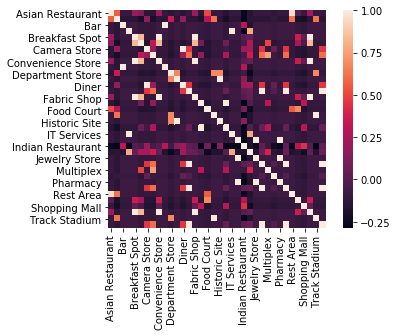

In [80]:
cor = areas_grouped.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [64]:
Related_Categories = cor[cor['Café']>0.7].index.drop('Café').tolist()
Related_Categories

['Breakfast Spot', 'Convenience Store', 'Fabric Shop', 'Snack Place']